<a href="https://colab.research.google.com/github/ikramuhibbana/Kelompok-1-Kecerdasan-Buatan-S2-UIN-SUKA/blob/main/Fine_Tuned_Artificial_Neural_Network_(ANN)_with_Explainable_AI_(XAI)_for_Classification_and_Interpretation_of_the_Wisconsin_Breast_Cancer_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================
# IMPORT LIBRARY
# ==============================================================
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

In [ ]:
# ==============================================================
# 1) LOAD DATASET
# ==============================================================
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# ==============================================================
# 2) SPLIT TRAIN-TEST
# ==============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================================================
# 3) NORMALISASI (PREPROCESSING)
# ==============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# ==============================================================
# 4) MEMBANGUN MODEL ANN
# ==============================================================
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ==============================================================
# 5) KOMPILASI MODEL
# ==============================================================
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ==============================================================
# 6) PELATIHAN MODEL
# ==============================================================
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7998 - loss: 0.4845 - val_accuracy: 0.9474 - val_loss: 0.2021
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9507 - loss: 0.2018 - val_accuracy: 0.9649 - val_loss: 0.1091
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9597 - loss: 0.1479 - val_accuracy: 0.9825 - val_loss: 0.0819
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9831 - loss: 0.0867 - val_accuracy: 0.9737 - val_loss: 0.0700
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9613 - loss: 0.0889 - val_accuracy: 0.9737 - val_loss: 0.0654
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9617 - loss: 0.1008 - val_accuracy: 0.9737 - val_loss: 0.0629
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.0595 - val_accuracy: 0.9737 - val_loss: 0.0635
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9911 - loss: 0.0489 - val_accuracy: 0.9737 - val_lo

Akurasi pada data test (sebelum fine-tuning): 96.49%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

 Evaluasi Lengkap Model Sebelum Fine-Tuning 
Akurasi : 0.9649
Presisi : 0.9718
Recall : 0.9718
F1-Score : 0.9718


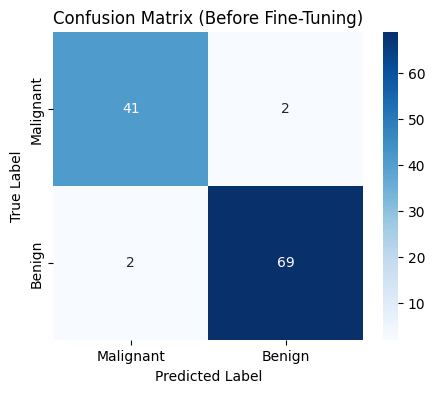

In [ ]:
# ==============================================================
# 7) EVALUASI MODEL
# ==============================================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi pada data test (sebelum fine-tuning): {acc*100:.2f}%")

# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc_before = accuracy_score(y_test, y_pred)
prec_before = precision_score(y_test, y_pred)
rec_before = recall_score(y_test, y_pred)
f1_before = f1_score(y_test, y_pred)

print("\n Evaluasi Lengkap Model Sebelum Fine-Tuning ")
print(f"Akurasi : {acc_before:.4f}")
print(f"Presisi : {prec_before:.4f}")
print(f"Recall : {rec_before:.4f}")
print(f"F1-Score : {f1_before:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Before Fine-Tuning)")
plt.show()

In [ ]:
# ==============================================================
# 8) FINE-TUNING MODEL ANN
# ==============================================================

# Callback untuk menghentikan training lebih awal bila tidak ada peningkatan
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Clone dan lanjutkan bobot lama
fine_tuned_model = tf.keras.models.clone_model(model)
fine_tuned_model.set_weights(model.get_weights())

# Compile dengan learning rate lebih kecil
fine_tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune (lanjutkan training)
history_ft = fine_tuned_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9957 - loss: 0.0213 - val_accuracy: 0.9649 - val_loss: 0.0833
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0269 - val_accuracy: 0.9649 - val_loss: 0.0828
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9917 - loss: 0.0177 - val_accuracy: 0.9649 - val_loss: 0.0830
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9905 - loss: 0.0214 - val_accuracy: 0.9649 - val_loss: 0.0827
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9884 - loss: 0.0305 - val_accuracy: 0.9649 - val_loss: 0.0832
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.0215 - val_accuracy: 0.9649 - val_loss: 0.0833
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9860 - loss: 0.0523 - val_accuracy: 0.9649 - val_loss: 0.0831
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.0173 - val_accuracy: 0.9649 - val_loss


Akurasi setelah fine-tuning: 97.37%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 Evaluasi Lengkap Fine-Tuned Model 
Akurasi : 0.9737
Presisi : 0.9722
Recall : 0.9859
F1-Score : 0.9790

Classification Report (Fine-Tuned Model):
              precision    recall  f1-score   support

   Malignant       0.98      0.95      0.96        43
      Benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



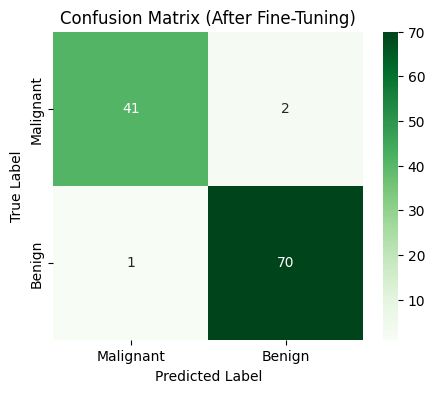

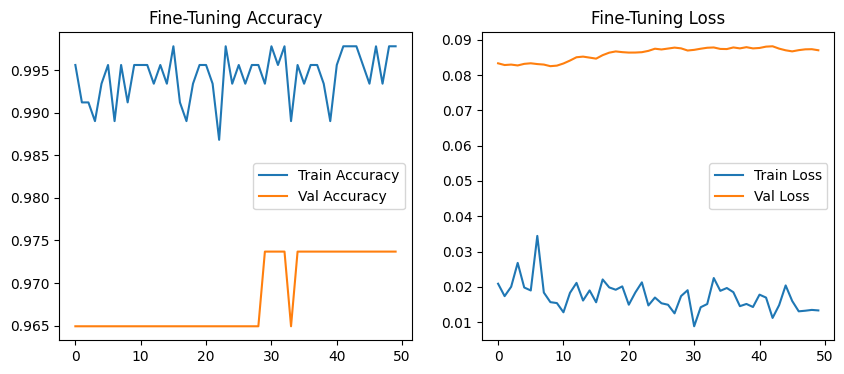

In [ ]:
# ==============================================================
# 9) EVALUASI SETELAH FINE-TUNING
# ==============================================================
loss_ft, acc_ft = fine_tuned_model.evaluate(X_test, y_test, verbose=0)
print(f"\nAkurasi setelah fine-tuning: {acc_ft*100:.2f}%")

y_pred_prob_ft = fine_tuned_model.predict(X_test)
y_pred_ft = (y_pred_prob_ft > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred_ft)
prec = precision_score(y_test, y_pred_ft)
rec = recall_score(y_test, y_pred_ft)
f1 = f1_score(y_test, y_pred_ft)

print("\n Evaluasi Lengkap Fine-Tuned Model ")
print(f"Akurasi : {acc:.4f}")
print(f"Presisi : {prec:.4f}")
print(f"Recall : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

# Classification Report
print("\nClassification Report (Fine-Tuned Model):")
print(classification_report(y_test, y_pred_ft, target_names=['Malignant', 'Benign']))

# Confusion Matrix Fine-Tuned
cm_ft = confusion_matrix(y_test, y_pred_ft)
plt.figure(figsize=(5,4))
sns.heatmap(cm_ft, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (After Fine-Tuning)")
plt.show()

# Plot Akurasi dan Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Val Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuning Loss')
plt.legend()
plt.show()


In [ ]:
# ==============================================================
# 10) XAI DENGAN SHAP (PADA MODEL FINE-TUNED)
# ==============================================================

# Ambil sebagian data training untuk efisiensi
X_background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Pastikan output model berbentuk (n_samples, 1)
explainer = shap.KernelExplainer(lambda x: fine_tuned_model.predict(x).reshape(-1, 1), X_background)

# Hitung SHAP values
shap_values = explainer.shap_values(X_test[:50], nsamples=300)

# Pastikan format shap_values benar
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Jika SHAP values punya dimensi tambahan (misalnya 3D), ubah ke 2D
if shap_values.ndim == 3:
    shap_values = shap_values[:, :, 0]
elif shap_values.ndim == 1:
    shap_values = shap_values.reshape(-1, 1)

print("SHAP shape:", shap_values.shape)
print("X_test shape:", X_test[:50].shape)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
938/938 ━━━━━━

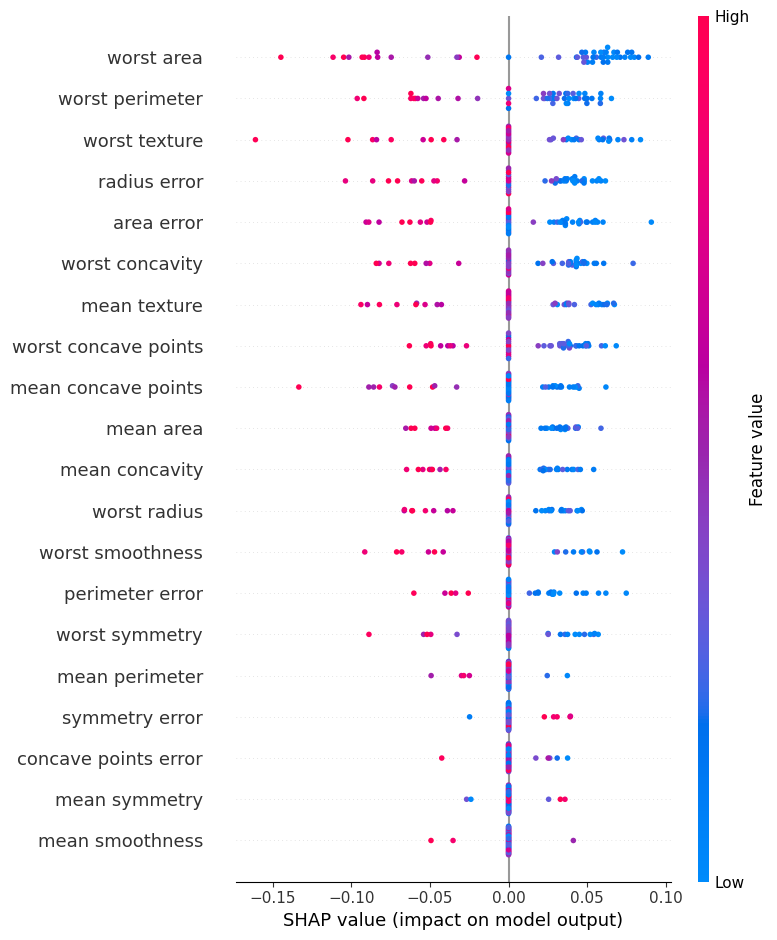

In [ ]:
# Plot summary
shap.summary_plot(shap_values, X_test[:50], feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot_finetuned.png", dpi=300, bbox_inches='tight')
plt.show()

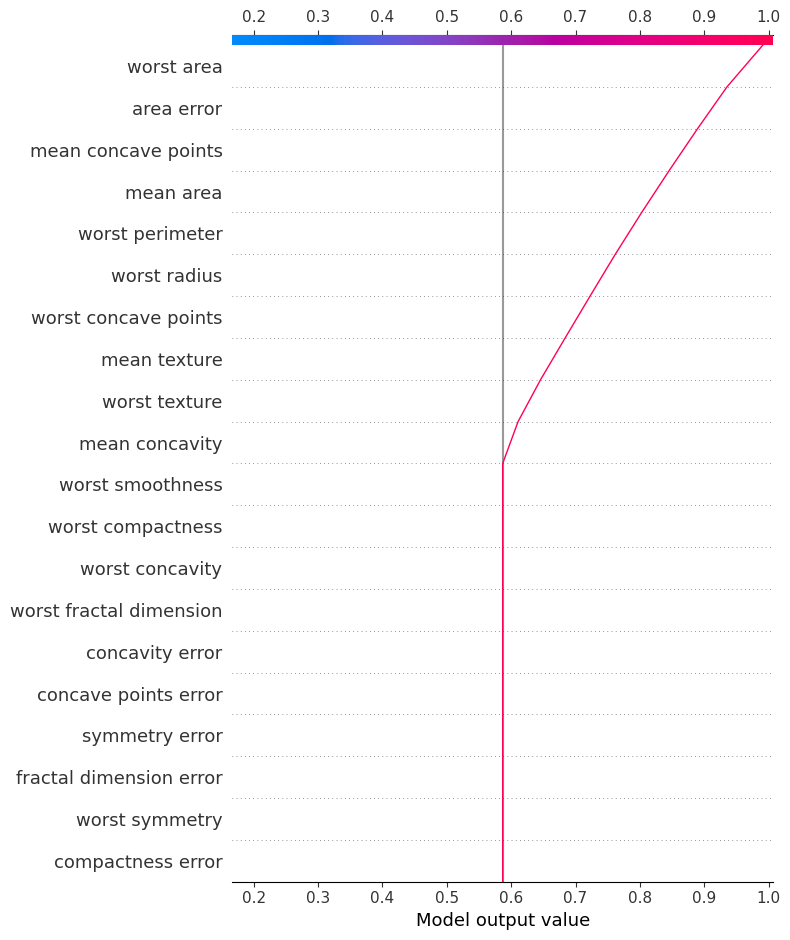

In [ ]:
# Decision Plot
sample_idx = 0  # pilih satu sampel data
plt.figure()
shap.decision_plot(
    explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value,
    shap_values[sample_idx],
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.savefig("shap_decision_plot_finetuned.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

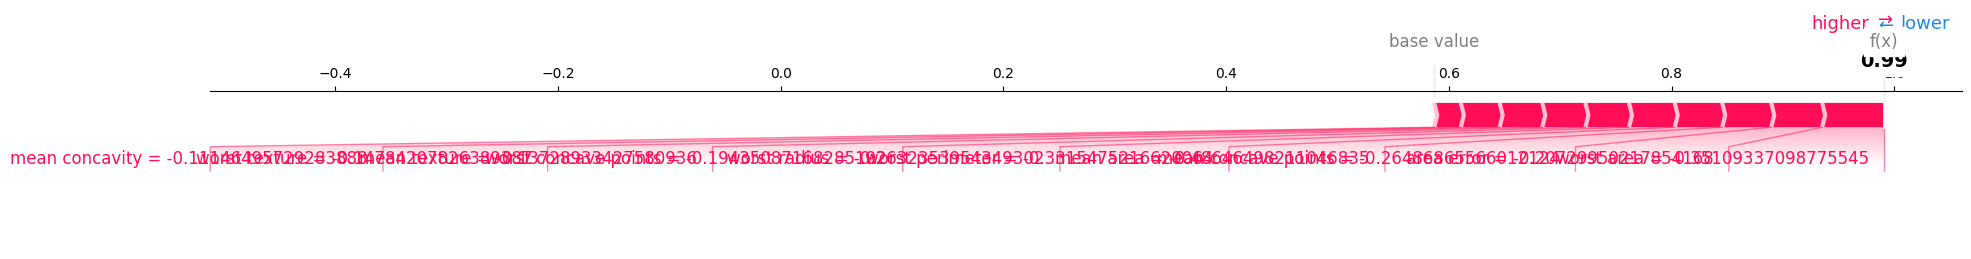

In [ ]:
# Force Plot
top_n = 10
sample_idx = 0

sv = shap_values[sample_idx]
top_idx = np.argsort(np.abs(sv))[::-1][:top_n]

# Plot force dengan matplotlib agar bisa disimpan
plt.figure()
shap.force_plot(
    explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value,
    sv[top_idx],
    X_test[sample_idx][top_idx],
    feature_names=feature_names[top_idx],
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.savefig("shap_force_plot_finetuned.png", dpi=300, bbox_inches='tight')
plt.show()

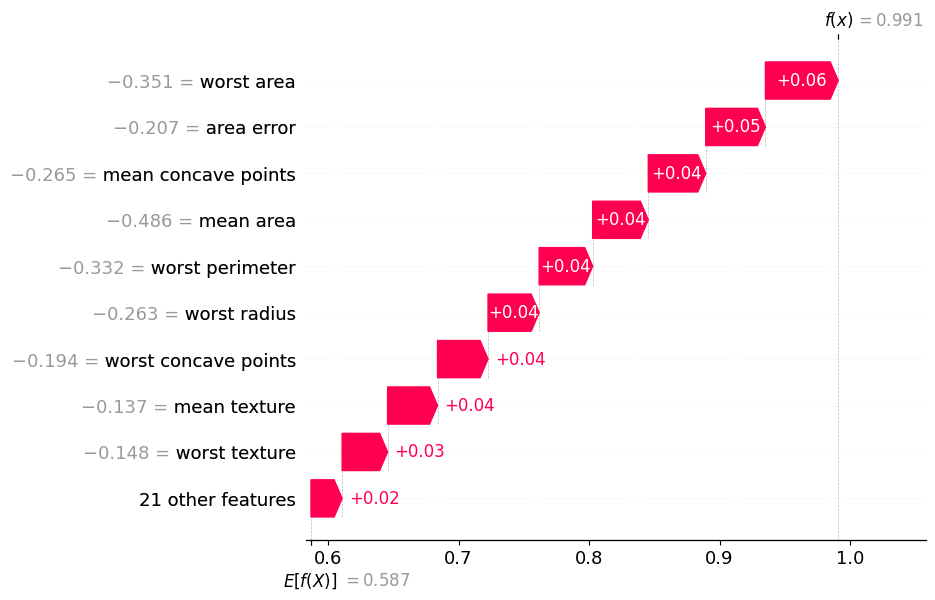

<Figure size 640x480 with 0 Axes>

In [ ]:
#waterfall plot
sample_idx = 0
plt.figure()
shap.plots.waterfall(
shap.Explanation(
values=shap_values[sample_idx],
base_values=explainer.expected_value,
data=X_test[sample_idx],
feature_names=feature_names
),
max_display=10
)
plt.tight_layout()
plt.savefig("shap_waterfall_plot_finetuned.png", dpi=300, bbox_inches='tight')
plt.show()